# Topic Modelling

In [175]:
import os
import re
import pandas as pd
from wordcloud import WordCloud
from glob import glob
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from multiprocessing import Pool
import matplotlib.pyplot as plt


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
import gensim.corpora as corpora
import pyLDAvis
from pyLDAvis import gensim_models
# import pyLDAvis.gensim
from textacy.tm import TopicModel
from guidedlda import GuidedLDA
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the topics
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/syip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load dataset

In [3]:
file_list = glob('blogs/*')
print(f"Total file count: {len(file_list)}")
file_list[:5]

Total file count: 19320


['blogs/4162441.male.16.Student.Sagittarius.xml',
 'blogs/3489929.female.25.Student.Cancer.xml',
 'blogs/3954575.female.23.BusinessServices.Gemini.xml',
 'blogs/3364931.male.16.Student.Virgo.xml',
 'blogs/3162067.female.24.Education.Cancer.xml']

In [4]:
def extractTextFromElement(elementName, xml_file):
    stringofxml = open(xml_file).read()
    text = ''
    tree = ET.fromstring(stringofxml)
    for child in tree:
        if child.tag == elementName:
            text += child.text.strip()
    return text

print(extractTextFromElement(elementName='post', xml_file=file_list[0]))

DESTINY...       you might not say anything     but i can hear     you have chosen me, your life partner     so have i dear,     so have i dear....      my first dream, my first extreme,     my first love, i was waiting for my DESTINY.     what should i do with myself,     tell me o' my heart     what should i do with myself,     tell me....      should i fly, with this beautiful nature.     or should i play with these winds.     should i try to reach the skies,     or should i pray to the mother earth.     what should i do with myself friends     tell me....      she talked in such a way,     gave me dreams with thousand colours.     like i stand in the middle of island,     and she shows me all the love she has,     my first dream , my first extreme,     my first love, i was waiting for my DESTINY.           --NILDEAR ANGEL..      you say it or you don't,     but i can see it in your eyes,     some words are not worth saying,     they try to remain in your heart.     i saw it years a

In [122]:
# dct = {idx:extractTextFromElement('post',file) for idx, file in enumerate(file_list[:600])}
# lst = [extractTextFromElement('post',file) for file in file_list[400:600]]

lst=[]
for file in tqdm(file_list[800:1600]):
    try:
        res = extractTextFromElement('post',file)
        lst.append(res)
    except Exception:
        continue
print(f"Loaded {len(lst)} files. ")

  0%|          | 0/800 [00:00<?, ?it/s]

Loaded 330 files. 


## Exploratory - word cloud

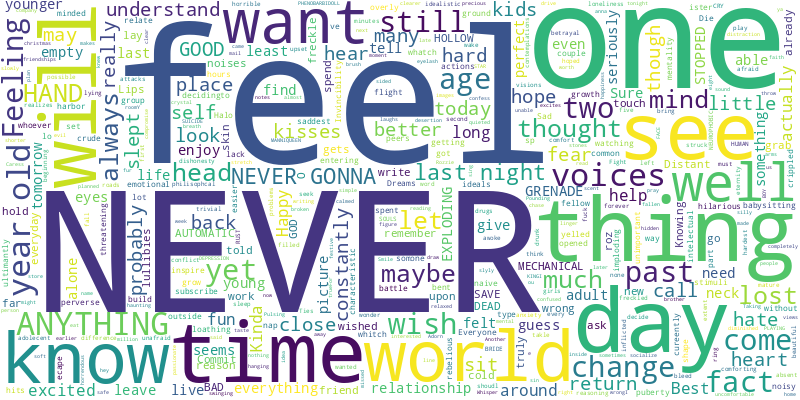

In [123]:
wordcloud = WordCloud(background_color="white", max_words=5000,
                      contour_width=3, contour_color='steelblue',
                      width=800, height=400)

# Generate a word cloud
wordcloud.generate(lst[5])

# Visualize the word cloud
wordcloud.to_image()

## Data Prep
### Stopwords

In [189]:
custom_stop_words = set(stopwords.words("english")).union({
        'urllink', 
    "a",
"able",
"about",
"above",
"abst",
"accordance",
"according",
"accordingly",
"across",
"act",
"actually",
"added",
"adj",
"affected",
"affecting",
"affects",
"after",
"afterwards",
"again",
"against",
"ah",
"all",
"almost",
"alone",
"along",
"already",
"also",
"although",
"always",
"am",
"among",
"amongst",
"an",
"and",
"announce",
"another",
"any",
"anybody",
"anyhow",
"anymore",
"anyone",
"anything",
"anyway",
"anyways",
"anywhere",
"apparently",
"approximately",
"are",
"aren",
"arent",
"arise",
"around",
"as",
"aside",
"ask",
"asking",
"at",
"auth",
"available",
"away",
"awfully",
"b",
"back",
"be",
"became",
"because",
"become",
"becomes",
"becoming",
"been",
"before",
"beforehand",
"begin",
"beginning",
"beginnings",
"begins",
"behind",
"being",
"believe",
"below",
"beside",
"besides",
"between",
"beyond",
"biol",
"both",
"brief",
"briefly",
"but",
"by",
"c",
"ca",
"came",
"can",
"cannot",
"can't",
"cause",
"causes",
"certain",
"certainly",
"co",
"com",
"come",
"comes",
"contain",
"containing",
"contains",
"could",
"couldnt",
"d",
"date",
"did",
"didn't",
"different",
"do",
"does",
"doesn't",
"doing",
"done",
"don't",
"down",
"downwards",
"due",
"during",
"e",
"each",
"ed",
"edu",
"effect",
"eg",
"eight",
"eighty",
"either",
"else",
"elsewhere",
"end",
"ending",
"enough",
"especially",
"et",
"et-al",
"etc",
"even",
"ever",
"every",
"everybody",
"everyone",
"everything",
"everywhere",
"ex",
"except",
"f",
"far",
"few",
"ff",
"fifth",
"first",
"five",
"fix",
"followed",
"following",
"follows",
"for",
"former",
"formerly",
"forth",
"found",
"four",
"from",
"further",
"furthermore",
"g",
"gave",
"get",
"gets",
"getting",
"give",
"given",
"gives",
"giving",
"go",
"goes",
"going",
"gone",
"got",
"gotten",
"h",
"had",
"happens",
"hardly",
"has",
"hasn't",
"have",
"haven't",
"having",
"he",
"hed",
"hence",
"her",
"here",
"hereafter",
"hereby",
"herein",
"heres",
"hereupon",
"hers",
"herself",
"hes",
"hi",
"hid",
"him",
"himself",
"his",
"hither",
"home",
"how",
"howbeit",
"however",
"hundred",
"i",
"id",
"ie",
"if",
"i'll",
"im",
"immediate",
"immediately",
"importance",
"important",
"in",
"inc",
"indeed",
"index",
"information",
"instead",
"into",
"invention",
"inward",
"is",
"isn't",
"it",
"itd",
"it'll",
"its",
"itself",
"i've",
"j",
"just",
"k",
"keep",
"keeps",
"kept",
"kg",
"km",
"know",
"known",
"knows",
"l",
"largely",
"last",
"lately",
"later",
"latter",
"latterly",
"least",
"less",
"lest",
"let",
"lets",
"like",
"liked",
"likely",
"line",
"little",
"'ll",
"look",
"looking",
"looks",
"ltd",
"m",
"made",
"mainly",
"make",
"makes",
"many",
"may",
"maybe",
"me",
"mean",
"means",
"meantime",
"meanwhile",
"merely",
"mg",
"might",
"million",
"miss",
"ml",
"more",
"moreover",
"most",
"mostly",
"mr",
"mrs",
"much",
"mug",
"must",
"my",
"myself",
"n",
"na",
"name",
"namely",
"nay",
"nd",
"near",
"nearly",
"necessarily",
"necessary",
"need",
"needs",
"neither",
"never",
"nevertheless",
"new",
"next",
"nine",
"ninety",
"no",
"nobody",
"non",
"none",
"nonetheless",
"noone",
"nor",
"normally",
"nos",
"not",
"noted",
"nothing",
"now",
"nowhere",
"o",
"obtain",
"obtained",
"obviously",
"of",
"off",
"often",
"oh",
"ok",
"okay",
"old",
"omitted",
"on",
"once",
"one",
"ones",
"only",
"onto",
"or",
"ord",
"other",
"others",
"otherwise",
"ought",
"our",
"ours",
"ourselves",
"out",
"outside",
"over",
"overall",
"owing",
"own",
"p",
"page",
"pages",
"part",
"particular",
"particularly",
"past",
"per",
"perhaps",
"placed",
"please",
"plus",
"poorly",
"possible",
"possibly",
"potentially",
"pp",
"predominantly",
"present",
"previously",
"primarily",
"probably",
"promptly",
"proud",
"provides",
"put",
"q",
"que",
"quickly",
"quite",
"qv",
"r",
"ran",
"rather",
"rd",
"re",
"readily",
"really",
"recent",
"recently",
"ref",
"refs",
"regarding",
"regardless",
"regards",
"related",
"relatively",
"research",
"respectively",
"resulted",
"resulting",
"results",
"right",
"run",
"s",
"said",
"same",
"saw",
"say",
"saying",
"says",
"sec",
"section",
"see",
"seeing",
"seem",
"seemed",
"seeming",
"seems",
"seen",
"self",
"selves",
"sent",
"seven",
"several",
"shall",
"she",
"shed",
"she'll",
"shes",
"should",
"shouldn't",
"show",
"showed",
"shown",
"showns",
"shows",
"significant",
"significantly",
"similar",
"similarly",
"since",
"six",
"slightly",
"so",
"some",
"somebody",
"somehow",
"someone",
"somethan",
"something",
"sometime",
"sometimes",
"somewhat",
"somewhere",
"soon",
"sorry",
"specifically",
"specified",
"specify",
"specifying",
"still",
"stop",
"strongly",
"sub",
"substantially",
"successfully",
"such",
"sufficiently",
"suggest",
"sup",
"sure	t",
"take",
"taken",
"taking",
"tell",
"tends",
"th",
"than",
"thank",
"thanks",
"thanx",
"that",
"that'll",
"thats",
"that've",
"the",
"their",
"theirs",
"them",
"themselves",
"then",
"thence",
"there",
"thereafter",
"thereby",
"thered",
"therefore",
"therein",
"there'll",
"thereof",
"therere",
"theres",
"thereto",
"thereupon",
"there've",
"these",
"they",
"theyd",
"they'll",
"theyre",
"they've",
"think",
"this",
"those",
"thou",
"though",
"thoughh",
"thousand",
"throug",
"through",
"throughout",
"thru",
"thus",
"til",
"tip",
"to",
"together",
"too",
"took",
"toward",
"towards",
"tried",
"tries",
"truly",
"try",
"trying",
"ts",
"twice",
"two",
"u",
"un",
"under",
"unfortunately",
"unless",
"unlike",
"unlikely",
"until",
"unto",
"up",
"upon",
"ups",
"us",
"use",
"used",
"useful",
"usefully",
"usefulness",
"uses",
"using",
"usually",
"v",
"value",
"various",
"'ve",
"very",
"via",
"viz",
"vol",
"vols",
"vs",
"w",
"want",
"wants",
"was",
"wasnt",
"way",
"we",
"wed",
"welcome",
"we'll",
"went",
"were",
"werent",
"we've",
"what",
"whatever",
"what'll",
"whats",
"when",
"whence",
"whenever",
"where",
"whereafter",
"whereas",
"whereby",
"wherein",
"wheres",
"whereupon",
"wherever",
"whether",
"which",
"while",
"whim",
"whither",
"who",
"whod",
"whoever",
"whole",
"who'll",
"whom",
"whomever",
"whos",
"whose",
"why",
"widely",
"willing",
"wish",
"with",
"within",
"without",
"wont",
"words",
"world",
"would",
"wouldnt",
"www",
"x",
"y",
"yes",
"yet",
"you",
"youd",
"you'll",
"your",
"youre",
"yours",
"yourself",
"yourselves",
"you've",
"z",
"zero",
})

### UDFs

In [201]:
def remove_stopwords(tokens):
    tokens_without_sw = [word for word in tokens if word not in custom_stop_words]
    return tokens_without_sw

def remove_punctuation(string, sub=' '):
#     tokens_without_punc = [word for word in tokens if word not in [',','!','?','.','^','/']]
    string_without_punc = re.sub('[,\.!?:;`^]', sub, string)
    return string_without_punc

def remove_numbers(string, sub=''):
    string_without_numb = re.sub('\d*', sub, string)
    return string_without_numb

def process_text(text_string, rm_stopwords=True, rm_punctuation=True, rm_numbers=True):
    if rm_punctuation:
        text_string = remove_punctuation(string=text_string)
    if rm_numbers:
        text_string = remove_numbers(string=text_string)
        
    text_tokens = word_tokenize(text_string)
    if rm_stopwords:
        text_tokens = remove_stopwords(tokens=text_tokens)

    return " ".join(text_tokens)
    

In [202]:
lst_cleaned = [process_text(doc, 
                            rm_stopwords=True, 
                            rm_numbers=True,
                            rm_punctuation=True,
                           ) for doc in tqdm(lst)]

# with Pool(4) as p:
#     lst_cleaned = list(tqdm(p.imap(process_text, lst[:20])))

  0%|          | 0/330 [00:00<?, ?it/s]

In [203]:
remove_stopwords(tokens=word_tokenize('the urllink is broken'))

['broken']

## Training 
### with Gensim & pyLDAvis

In [204]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [193]:
tokens = list(sent_to_words(lst_cleaned))

In [205]:
# Create Dictionary
id2word = corpora.Dictionary(tokens)

# Term Document Frequency
corpus = [id2word.doc2bow(token) for token in tokens]


In [206]:
n_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)

In [207]:
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model,
                                                 corpus,
                                                 id2word)


In [208]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.002046 -0.000067       1        1  24.663773
7      0.010795  0.001292       2        1  19.476957
8      0.000201 -0.009085       3        1  13.628052
5      0.002216  0.003513       4        1  13.595301
0     -0.004707  0.001136       5        1   9.965722
2     -0.000813 -0.002094       6        1   5.521059
9     -0.000521  0.004222       7        1   4.880885
3     -0.000702 -0.000971       8        1   3.961767
1     -0.003097 -0.001503       9        1   2.651234
4     -0.005418  0.003556      10        1   1.655250, topic_info=         Term         Freq        Total Category  logprob  loglift
157       the  1989.000000  1989.000000  Default  30.0000  30.0000
159      time  1679.000000  1679.000000  Default  29.0000  29.0000
169      well  1728.000000  1728.000000  Default  28.0000  28.0000
529    people  1368.000000  1368.000000  Default  27.0000  27.0000
301        it  1610.000000  1610.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
341        my     8.879409   589.423866  Topic10  -6.2068  -0.0942
504      feel    10.151071   806.762157  Topic10  -6.0730  -0.2742
398        so    10.315975   950.177841  Topic10  -6.0568  -0.4217
2218  urllink     9.821066   892.328193  Topic10  -6.1060  -0.4081
1035       re     8.627154   560.013121  Topic10  -6.2356  -0.0718

[831 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
1          1  0.266695  accountable
1          2  0.266695  accountable
22314      5  0.552605       admits
27040      4  0.586741  agriculture
25468      1  0.255091        alisa
...      ...       ...          ...
24434      1  0.505668   晚上和康人家去剪頭髮
24435      1  0.499184        沒人會知道
24436      1  0.506864    發了令我心碎的考卷
24437      1  0.492802          的新聞
24438      1  0.520100    還吃了劉媽包的水餃

[2197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 9, 6, 1, 3, 10, 4, 2, 5])

### with Textacy & GuildedLDA

#### Vectorization

**CountVecterizer**  

Assigning weights by counting the occurence of words. Heavier weight is given to words with more frequent occurence.  

<br>


**TF-IDF Vectorerizer**

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.  
  
A word vector represents a document as a list of numbers, with one for each possible word of the corpus. Vectorizing a document is taking the text and creating one of these vectors, and the numbers of the vectors somehow represent the content of the text. TF-IDF enables us to gives us a way to associate each word in a document with a number that represents how relevant each word is in that document. Then, documents with similar, relevant words will have similar vectors, which is what we are looking for in a machine learning algorithm.  


In [127]:
params = {
    'decode_error': 'ignore', 
    'ngram_range': (1, 3), 
    'analyzer': 'word',
    'max_features': 2000,
    'stop_words': custom_stop_words,
#     'token_pattern': r'\b[^\d\W]{3,}\b',
    'use_idf': False,
    'norm': None
}


tfidf = TfidfVectorizer(**params)

In [128]:
lst_tokenised = tfidf.fit_transform(lst_cleaned) #.astype(int)
lst_tokenised

<330x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 72847 stored elements in Compressed Sparse Row format>

In [129]:
len(lst_cleaned)

330

In [130]:
lst_tokenised_int =  tfidf.fit_transform(lst_cleaned).astype(int)
lst_tokenised_int

<330x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 72847 stored elements in Compressed Sparse Row format>

In [131]:
words_mapping = {v: k for k, v in tfidf.vocabulary_.items()}

In [132]:
# lookup = vectorize(lambda idx: words_mapping[idx])

In [133]:
words_mapping

{1660: 'start',
 1755: 'teams',
 1799: 'time',
 1736: 'talked',
 934: 'june',
 1307: 'planning',
 1662: 'starting',
 1121: 'middle',
 1528: 'september',
 1211: 'number',
 1927: 'weeks',
 346: 'content',
 1747: 'taught',
 745: 'great',
 1762: 'telling',
 488: 'dreams',
 945: 'kids',
 899: 'involved',
 1986: 'year',
 1051: 'love',
 987: 'leaders',
 1693: 'students',
 1692: 'student',
 242: 'cared',
 754: 'growing',
 595: 'faith',
 1754: 'team',
 753: 'grow',
 1531: 'seriously',
 1049: 'lots',
 702: 'fun',
 1137: 'model',
 138: 'big',
 296: 'church',
 1597: 'small',
 752: 'groups',
 460: 'direction',
 1422: 'reasons',
 726: 'god',
 949: 'kind',
 137: 'bible',
 764: 'guys',
 1465: 'rob',
 1717: 'sure',
 159: 'blogs',
 1996: 'youth',
 1536: 'set',
 112: 'based',
 1072: 'major',
 1230: 'opinions',
 959: 'knowledge',
 1259: 'pass',
 816: 'help',
 730: 'good',
 693: 'friends',
 294: 'christian',
 1024: 'listen',
 1390: 'questions',
 615: 'favorite',
 169: 'books',
 660: 'focus',
 1430: 'relati

#### Model Selection
**Point 1**  
For LDA, you need to specify in advance the number of topics (**k**) in the underlying topic structure.  

<br>

**Point 2**  
In general, perplexity is a measurement of how well a probability model predicts a sample. In the context of Natural Language Processing, perplexity is one way to evaluate language models.

In [134]:
n_topics = 10

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=2
    )

In [135]:
lda.fit(lst_tokenised)
lda_out = lda.transform(lst_tokenised)

In [136]:
lda.perplexity(lst_tokenised_int)

1050.2975371872828

Use perplexity to evaluate models by comparing perplexity across different models with varying **k**'s. The model with the lowest perplexity is generally considered the “best”.

  0%|          | 0/28 [00:00<?, ?it/s]

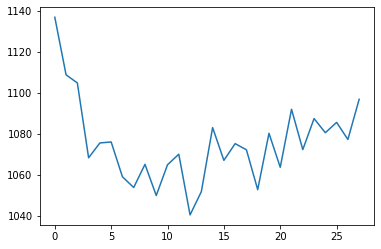

In [137]:
perplexity = []
for n_topics in tqdm(range(2, 30)):
    lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=2
    )
    lda.fit(lst_tokenised)
    lda_out = lda.transform(lst_tokenised)
    perplexity.append(lda.perplexity(lst_tokenised))
plt.plot(perplexity)

#### Determine No. of Topics

In [148]:
n_topics = 11

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=2
    )
lda.fit(lst_tokenised)
lda_out = lda.transform(lst_tokenised)

<AxesSubplot:>

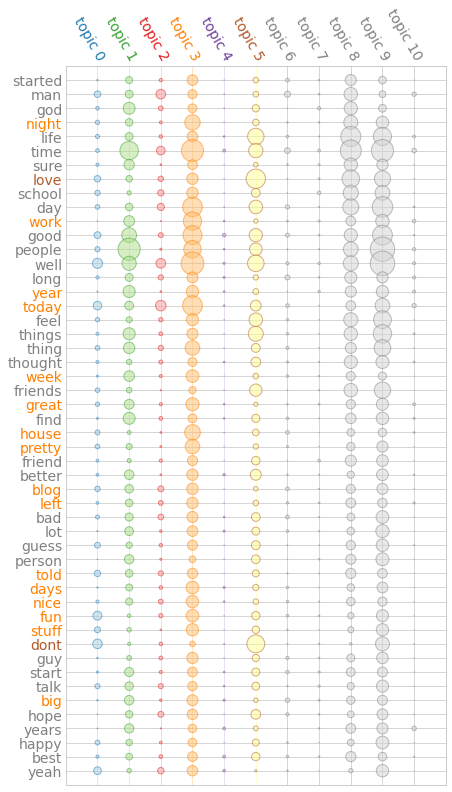

In [149]:
tm = TopicModel(lda, n_topics=n_topics)
tm.termite_plot(
    doc_term_matrix=tm.model.components_, 
    id2term=words_mapping, 
    topics=-1,
    n_terms=50,
    rank_terms_by='topic_weight', 
    highlight_topics=list(range(6))
)

In [152]:
tm.top_topic_terms(id2term=words_mapping, topics=-1, top_n=n_topics, weights=False)

<generator object TopicModel.top_topic_terms at 0x7fa8aea28e50>

TypeError: score() missing 1 required positional argument: 'X'

## Reference
- Perplexity: https://cfss.uchicago.edu/notes/topic-modeling/#:~:text=Perplexity%20is%20a%20statistical%20measure,of%20words%20in%20your%20documents.   
- LDA Beginner's Guide: https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2    
- Textacy Doc: https://buildmedia.readthedocs.org/media/pdf/textacy/latest/textacy.pdf
